# Analise de Jogos mais Jogados da Steam
---

## Integrantes:
- Samuel Santos;
- Pedro Henrique;
- Leonardo Filho;
- Sean Lucas.

---

## Introdução:

---

## Dados Usados:

---
## Importações para Pré-processamento e Analises:

In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import linregress

---

## Pré-processamento:

### Formatando Datas de Lançamentos dos Jogos
Como as datas de lançamentos de cada jogo veio no formato "mes-escrito dia, ano", seria inviável utilizarmos esses dados para análise. Portanto, convertemos as datas para o formato DateTime para um uso mais viável.

In [173]:
# Formatando data de lançamento dos jogos
df_games_info = pd.read_csv("data/all_games_info.csv")

df_games_info["release_date"] = pd.to_datetime(df_games_info["release_date"])
df_games_info.to_csv("data/all_games_info.csv", index=False)

### Padronizando GPUS:

In [174]:
# padronizando GPUS pelos modelos e VRAM
#df_gpu = df_games_info["pc_requirements"].str.extract(r'(?i)\b(?:GB\s*(\d+)|(\d+)\s*GB|(?:GTX|GT|RTX|RT)\s*(\d+))\b', expand=True)
#df_gpu

# padrão único com grupos nomeados: vram1 (GB 16), vram2 (16 GB/16GB), sigla+gnum para GPUs
pattern = r'(?i)\b(?:GB\s*(?P<vram1>\d+)|(?P<vram2>\d+)\s*GB)|\b(?P<sigla>GTX|GT|RTX|RT)\s*(?P<gnum>\d{2,4})\b'

ex = df_games_info["pc_requirements"].str.extract(pattern)

# VRAM preferida (vram1 ou vram2)
vram = ex["vram1"].fillna(ex["vram2"])

# GPU (sigla + número), normalizada em maiúsculas; strings vazias -> NaN
gpu = (ex["sigla"].str.upper().fillna("") + " " + ex["gnum"].fillna("")).str.strip()
gpu = gpu.replace("", np.nan)

# combina: primeiro VRAM (com sufixo " GB"), se não houver usa a GPU encontrada
df_games_info["gpu_normalizado"] = vram.where(vram.notna(), gpu)
df_games_info.loc[vram.notna(), "gpu_normalizado"] = df_games_info.loc[vram.notna(), "gpu_normalizado"].astype(str) + " GB"


df_games_info.to_csv("data/all_games_info.csv", index=False)

In [175]:
vram_gpus = {
    1: [
        "GTX 550", "GTX 560", "GTX 650", "GT 420", "GTX 470", "GTX 580", "GTX 750", "GTX 430", "GTX 260", "GTX 600",
        "GTX 700", "GTX 750 Ti", "GTX 560 Ti", "GT 740"
    ],
    2: [
        "GTX 660", "GTX 680", "GTX 760", "GTX 770", "GT 710", "GT 1030", "GT 450", "GT 730", "GTX 950", "GTX 960",
        "GTX 1050", "GTX 460", "GTX 900", "GTX 1050 Ti", "GTX 670", "GTX 1060", "GTX 1650", "GTX 980", "GTX 980 Ti",
        "GTX 1080", "GTX 1070", "GTX 970", "GTX 1050-Ti", "GTX 750-Ti"
    ],
    3: [
        "GTX 780"
    ],
    4: [
        "GTX 1650", "GTX 970", "GTX 980", "GTX 950", "GTX 1050 Ti", "GTX 1060", "GTX 1070", "GTX 1080"
    ],
    6: [
        "GTX 980 Ti", "GTX 1060"
    ]
}

for vram, gpus in vram_gpus.items():
    for gpu in gpus:
        if gpu in df_games_info["gpu_normalizado"].values:
            df_games_info.loc[df_games_info["gpu_normalizado"] == gpu, "gpu_normalizado"] = f"{vram} GB"
            
df_games_info.to_csv("data/all_games_info.csv", index=False)


---
## Perguntas

In [176]:

df_games_info

,id,game,release_date,price_USD,genres,pc_requirements,gpu_normalizado
0,629760,MORDHAU,2019-04-29,29.99,"Action, Indie",NVIDIA GTX 680 or AMD equivalent,2 GB
1,427520,Factorio,2020-08-14,35.00,"Casual, Indie, Simulation, Strategy",DirectX 11 capable GPU with 1GB VRAM - GeForce...,1 GB
2,1551360,Forza Horizon 5,2021-11-08,59.99,"Action, Adventure, Racing, Simulation, Sports","NVidia GTX 970, AMD RX 470, OR Intel Arc A380",2 GB
3,582660,Black Desert,2017-05-24,9.99,"Action, Adventure, Massively Multiplayer, RPG,...","GeForce GTX 970, Radeon RX 480",2 GB
4,1716740,Starfield,2023-09-05,69.99,RPG,"AMD Radeon RX 5700, NVIDIA GeForce 1070 Ti",NaN
...,...,...,...,...,...,...,...
276,1172470,Apex Legends™,2020-11-04,0.00,"Action, Adventure, Free To Play","AMD Radeonâ¢ HD 7790, NVIDIA GeForceÂ® GTX 950",2 GB
277,1049590,Eternal Return,2023-07-19,0.00,"Indie, Strategy, Free To Play","NVIDIA GeForce GTX 660, ATI Radeon HD 7850",2 GB
278,1448440,Wo Long: Fallen Dynasty,2023-03-03,39.99,"Action, Adventure, RPG",GeForce GTX 1650 4GBãRadeon RX 570 4GB,2 GB
279,203770,Crusader Kings II,2012-02-14,0.00,"RPG, Simulation, Strategy, Free To Play",GeForce GTX 1650 4GBãRadeon RX 570 4GB,2 GB


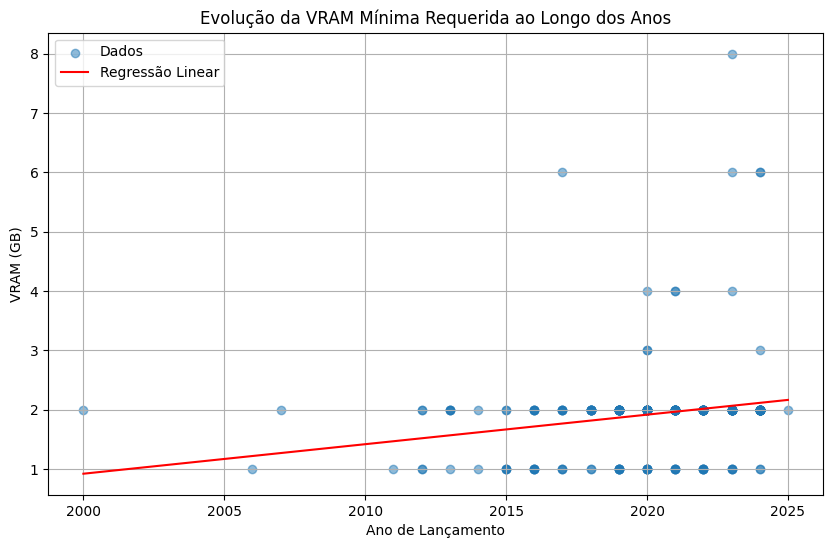

In [193]:
df_filtrado = df_games_info.dropna(subset=["gpu_normalizado", "release_date"]).copy().sort_values(by="release_date")
vram_extraida = df_filtrado["gpu_normalizado"].str.extract(r'(?P<vram>\d+)\s*GB', expand=True)
vram_extraida = vram_extraida.astype(float)
data_year = df_filtrado["release_date"].dt.year

vram_series = vram_extraida["vram"]

# Junta com os anos e elimina linhas com NaN
df_reg = pd.DataFrame({
    "ano": data_year,
    "vram": vram_series
}).dropna()

# Regressão só com valores válidos
result = linregress(df_reg["ano"], df_reg["vram"])

# Plotagem
plt.figure(figsize=(10, 6))
plt.scatter(df_reg["ano"], df_reg["vram"], alpha=0.5, label="Dados")
plt.plot(df_reg["ano"], result.intercept + result.slope * df_reg["ano"], color='red', label="Regressão Linear")
plt.xlabel("Ano de Lançamento")
plt.ylabel("VRAM (GB)")
plt.title("Evolução da VRAM Mínima Requerida ao Longo dos Anos")
plt.legend()
plt.grid(True)
plt.show()




